In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
import geopandas as gpd
import xarray as xr
import rioxarray
import matplotlib.gridspec as gridspec
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cf
import regionmask
from cmcrameri import cm
from xhistogram.xarray import histogram
shp_pan = gpd.read_file(r'Data\shapefiles\panamz.geojson')
folder_metric = r'Data\Datasets\amz\ent\clim'
datasets = ['cru', 'gpcc', 'chirps','imerg', 'terra', 'era_land', 'jra55','merra2']
datasets_names = ['CRU', 'GPCC', 'CHIRPS','IMERG-V6', 'TerraClimate', 'ERA5-Land', 'JRA55','MERRA2']
stations = gpd.read_file(r'Data\Datasets\amz\ent\stations.geojson')
regions = gpd.read_file(r'Data\shapefiles\ANA_amz.geojson', driver='GeoJSON')
regions_mask = regionmask.from_geopandas(regions, names='Region')

In [3]:
from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 18})
regions_list = ['Western', 'Northern', 'Southern', 'Eastern']
regions_replace = { 0:'Southern', 1:'Eastern',2:'Western', 3:'Northern'}
letters_22 = ['j)', 'k)', 'l)', 'm)']
wong = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#999999']
wong_b = ['#882255','#E69F00','#56B4E9','#009E73','#F0E442','#0072B2','#D55E00','#CC79A7','#000000']
hue_order = datasets_names.copy()
hue_order.append('Stations')
legend_elements = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong[i], markersize=12) for i in range(len(wong))]
legend_elements_b = [Line2D([0], [0],  marker='s', color='w', label=hue_order[i], markerfacecolor=wong_b[i], markersize=12) for i in range(len(wong_b))]


# clim

In [20]:
path_ent = r'Data\Datasets\amz\ent\clim'
path_mcwd = r'Data\Datasets\amz\mcwd\clim'
path_dsl = r'Data\Datasets\amz\dsl\clim'

ds_clim = {}
for i, dataset in enumerate(datasets):
    list_ds = []
    #open the dataset
    for path in [path_ent, path_mcwd, path_dsl]:
        ds = xr.open_dataset(os.path.join(path, dataset + '.nc'))
        mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
        ds['Region'] = mask
        list_ds.append(ds)
    
    #save in the dictionary with key as dataset name
    ds_clim[datasets_names[i]] = xr.merge(list_ds)

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: Sh

In [21]:
from scipy import stats
bins_ent = np.linspace(0, 0.8, 50)
bins_mcwd = np.linspace(-700, 0, 100)
bins_dsl = np.linspace(0, 12, 70)

In [22]:
def pearson_df(ds_dict, metric1, metric2):
    pearson_r_dict = {}
    for i, name in enumerate(ds_dict):
        ds = ds_dict[name].to_dataframe().reset_index().dropna()
        pearson_r_dict[name] = stats.pearsonr(ds[metric1], ds[metric2])[0]

    pearson_r = pd.DataFrame.from_dict(pearson_r_dict , orient='index', columns=['pearson_r'])
    pearson_r = pearson_r.reset_index().rename({'index': 'dataset'}, axis=1)
    pearson_r = pearson_r.sort_values(by='pearson_r', ascending=False)
    pearson_r.set_index('dataset', inplace=True)
    return pearson_r    

C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\1731981283.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


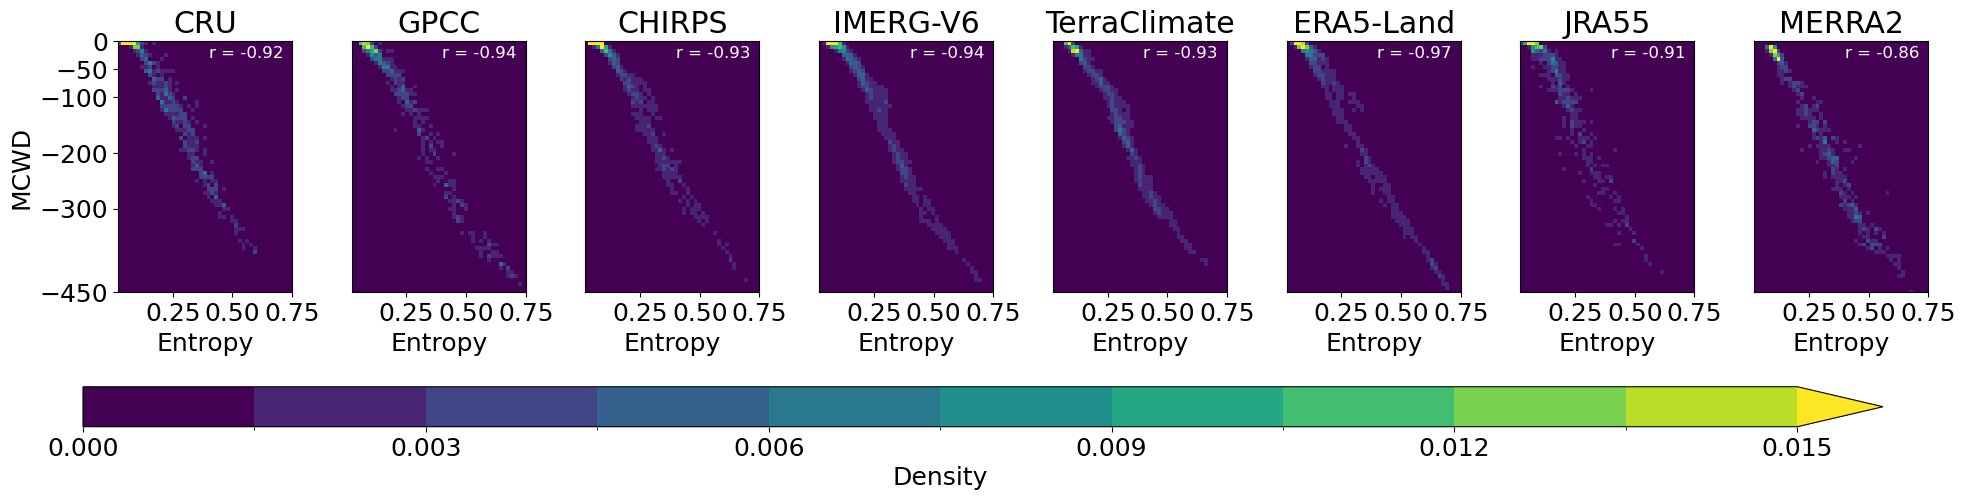

In [23]:
#plot RE X MCWD

vmin = 0
vmax = 0.015
levels = 11
cmap = mpl.cm.viridis
bounds = np.linspace(vmin,vmax, levels)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
bins_ent = np.linspace(0, 0.8, 50)
bins_mcwd = np.linspace(-700, 0, 100)

#plot the scatters
fig, axes = plt.subplots(ncols=len(datasets_names), nrows=1, figsize=(20, 4))
cax = fig.add_axes([0.05, -0.11, 0.9, 0.1])
fig.colorbar(sm, cax=cax, orientation='horizontal', label='Density')
pearson_r = pearson_df(ds_clim, 'ent', 'mcwd')
for i, name in enumerate(datasets_names):
    ds = ds_clim[name]
    h = histogram(ds.mcwd,ds.ent ,bins=[bins_mcwd, bins_ent])
    hh = h / h.sum()
    hh.plot(ax=axes[i], cmap=cmap,vmin=vmin, vmax=vmax, add_colorbar=False,  levels= levels)


    axes[i].set_title(name)
    axes[i].set_xlabel('Entropy')
    axes[i].set_xlim(0.02, 0.75)
    axes[i].set_ylim(-450, 0)
    axes[i].set_yticks([])
    axes[i].set_ylabel('')

    #axes[i].grid()
    #annotate the pearson r in the top right corner
    axes[i].annotate('r = ' + str(round(pearson_r.loc[name].pearson_r, 2)), xy=(0.40, -30), xycoords='data', fontsize=12, color='white')
axes[0].set_yticks([0,  -50, -100,  -200, -300, -450])
axes[0].set_ylabel('MCWD')
plt.tight_layout()

C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\2633545020.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


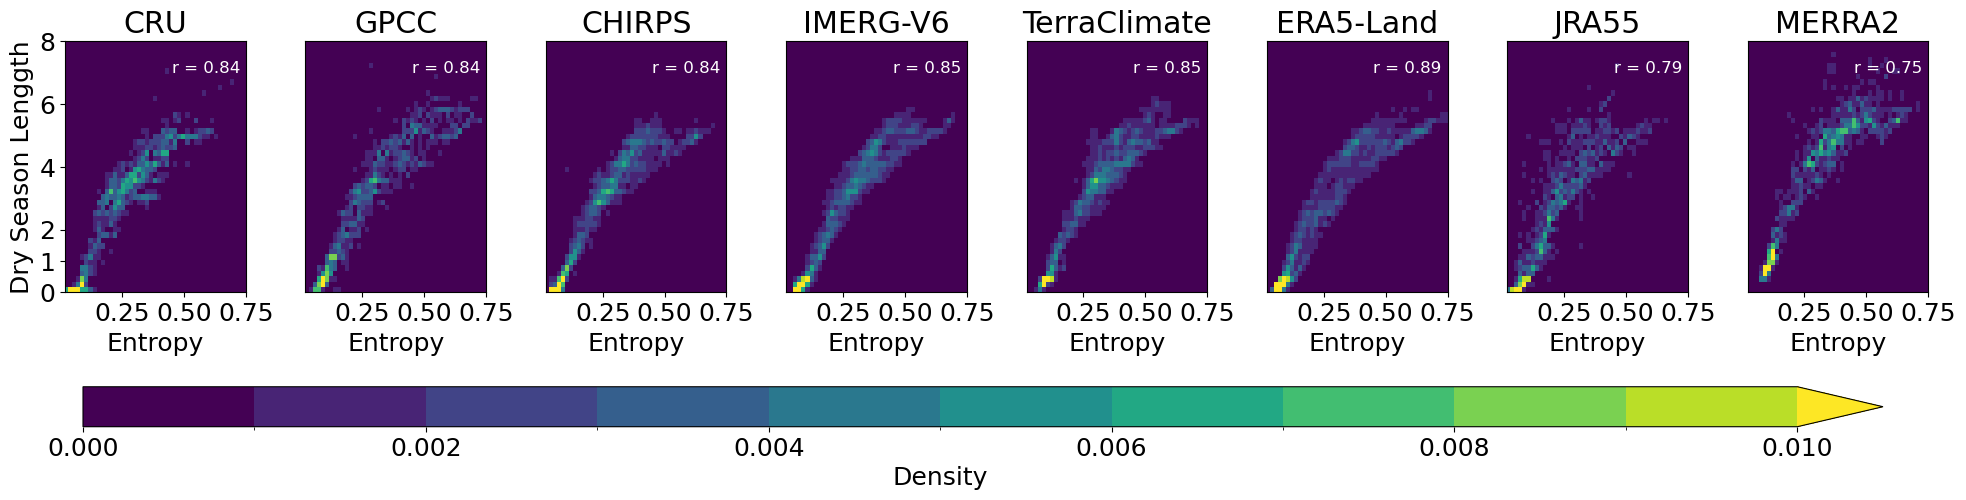

In [25]:
# plot RE X DSL

vmin = 0
vmax = 0.01
levels = 11
cmap = mpl.cm.viridis
bounds = np.linspace(vmin,vmax, levels)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
#plot the scatters
fig, axes = plt.subplots(ncols=len(datasets_names), nrows=1, figsize=(20, 4))
cax = fig.add_axes([0.05, -0.11, 0.9, 0.1])
fig.colorbar(sm, cax=cax, orientation='horizontal', label='Density')
pearson_r = pearson_df(ds_clim, 'ent', 'dsl')

for i, name in enumerate(datasets_names):
    ds = ds_clim[name]
    h = histogram(ds.dsl,ds.ent ,bins=[bins_dsl, bins_ent])
    hh = h / h.sum()
    hh.plot(ax=axes[i], cmap=cmap,vmin=vmin, vmax=vmax, add_colorbar=False,  levels= levels)


    axes[i].set_title(name)
    axes[i].set_xlabel('Entropy')
    axes[i].set_xlim(0.02, 0.75)
    axes[i].set_ylim(0, 8)
    axes[i].set_yticks([])
    axes[i].set_ylabel('')

    #axes[i].grid()
    #annotate the pearson r in the top right corner
    axes[i].annotate('r = ' + str(round(pearson_r.loc[name].pearson_r, 2)), xy=(0.45, 7), xycoords='data', fontsize=12, color='white')
axes[0].set_yticks([0,1,2,4,6,8])
axes[0].set_ylabel('Dry Season Lenggth')
plt.tight_layout()

C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\3279361300.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


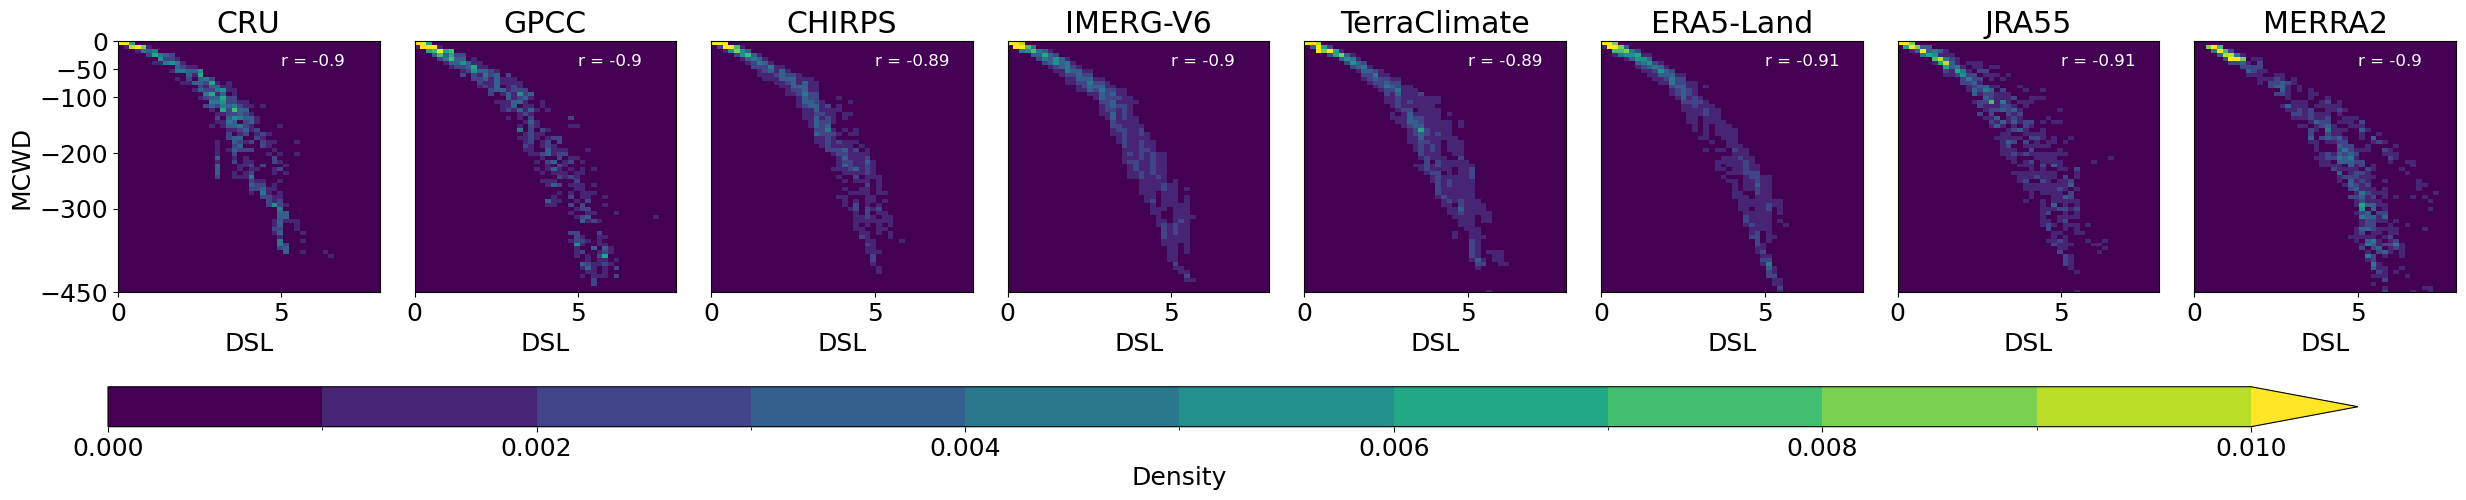

In [26]:
# plot MCWD X DSL

vmin = 0
vmax = 0.01
levels = 11
cmap = mpl.cm.viridis
bounds = np.linspace(vmin,vmax, levels)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend='max')
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm._A = []
#plot the scatters
fig, axes = plt.subplots(ncols=len(datasets_names), nrows=1, figsize=(25, 4))
cax = fig.add_axes([0.05, -0.11, 0.9, 0.1])
fig.colorbar(sm, cax=cax, orientation='horizontal', label='Density')
pearson_r = pearson_df(ds_clim, 'mcwd', 'dsl')

for i, name in enumerate(datasets_names):
    ds = ds_clim[name]
    h = histogram(ds.mcwd,ds.dsl ,bins=[bins_mcwd, bins_dsl])
    hh = h / h.sum()
    hh.plot(ax=axes[i], cmap=cmap,vmin=vmin, vmax=vmax, add_colorbar=False,  levels= levels)


    axes[i].set_title(name)
    axes[i].set_xlabel('DSL')
    axes[i].set_xlim(0, 8)
    axes[i].set_ylim(-450, 0)

    #axes[i].set_ylim(0, 8)
    axes[i].set_yticks([])
    axes[i].set_ylabel('')

    #axes[i].grid()
    #annotate the pearson r in the top right corner
    axes[i].annotate('r = ' + str(round(pearson_r.loc[name].pearson_r, 2)), xy=(5, -45), xycoords='data', fontsize=12, color='white')
axes[0].set_yticks([0,  -50, -100,  -200, -300, -450])
axes[0].set_ylabel('MCWD')
plt.tight_layout()

# ts

In [27]:
from Data.utils.evaluation import calculate_metrics, create_metrics_dataframe,  datasets_05
from Data.utils.datasets_plotting import plot_datasets33_nostat

path_ent = r'Data\Datasets\amz\ent'
path_mcwd = r'Data\Datasets\amz\mcwd'
path_dsl = r'Data\Datasets\amz\dsl'

datasets_all = {}
for i, dataset in enumerate(datasets):
    list_ds = []
    #open the dataset
    for path in [path_ent, path_mcwd, path_dsl]:
        ds = xr.open_dataset(os.path.join(path, dataset + '.nc'))
        mask = regions_mask.mask(ds, lon_name='lon', lat_name='lat')
        ds['Region'] = mask
        list_ds.append(ds)
    
    #save in the dictionary with key as dataset name
    datasets_all[datasets_names[i]] = xr.merge(list_ds)

c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  arr[:] = geometry
c:\Users\luisg\anaconda3\envs\geo_env\lib\site-packages\pygeos\io.py:518: Sh

In [67]:
#letters_22_eva = ['i)','j)', 'k)', 'l)']
def r_ts_plot(ds_all, metric1, metric2, label_cbar, vmin=-1, vmax=0, levels=11, cmap=mpl.cm.cividis,extend_cbar = 'max', extend=[-81, -42, -20, 11], proj = ccrs.Mercator()):
    #create a dictionary withh all datasets
    bounds = np.linspace(vmin,vmax, levels)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N, extend=extend_cbar)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm._A = []

    #corerlation in the time series between ent and mcwd
    pearson_r_ts = {}
    for i, name in enumerate(ds_all):
        ds = ds_all[name]
        dr = xr.corr(ds[metric1], ds[metric2], dim='year').to_dataset(name='r')
        dr['Region'] = ds['Region'] 
        pearson_r_ts[name] = dr

    df = pd.DataFrame()
    for name in datasets_names:
        ds = pearson_r_ts[name]
        dff =  ds.to_dataframe().dropna().reset_index()
        dff['Dataset'] = name
        df = df.append(dff)
    df = df[['r', 'Region', 'Dataset']]
    df['Region'] = df['Region'].replace(regions_replace)
    
    fig = plt.figure(layout='constrained', figsize=(20, 10))
    subfigs = fig.subfigures(1, 2)
    axs_right = subfigs[1].subplots(2, 2, sharex=True, sharey=True)
    axs_right = axs_right.flatten()
    for i, region in enumerate(regions_list):
        #boxplot of df
        sns.boxplot( y=var, data=df[df.Region==region], ax=axs_right[i], hue_order=hue_order, palette=wong, hue='Dataset',x='Dataset',dodge=False).get_legend().remove()
        axs_right[i].set_title(region)
        axs_right[i].set_xlabel('')
        axs_right[i].tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) 
        axs_right[i].set_ylabel(label_cbar)
        axs_right[i].set_ylim([vmin, vmax])
        #axs_right[i].text(0.92,0.96,  letters_22_eva[i], transform=axs_right[i].transAxes,  fontsize=18, va='top', ha='right')
        if i % 2 == 0:
            axs_right[i].set_ylabel(label_cbar)
        else:
            axs_right[i].set_ylabel('')
    #create legend in the bottom center of the figure
    subfigs[1].legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.06), loc='lower center', ncol=5, frameon=False, fontsize=12)
    plot_datasets33_nostat(subfigs[0], datasets_names, pearson_r_ts,  regions, vmin, vmax, levels, cmap, extend_cbar, 'r', 'r', label_cbar)



C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecat

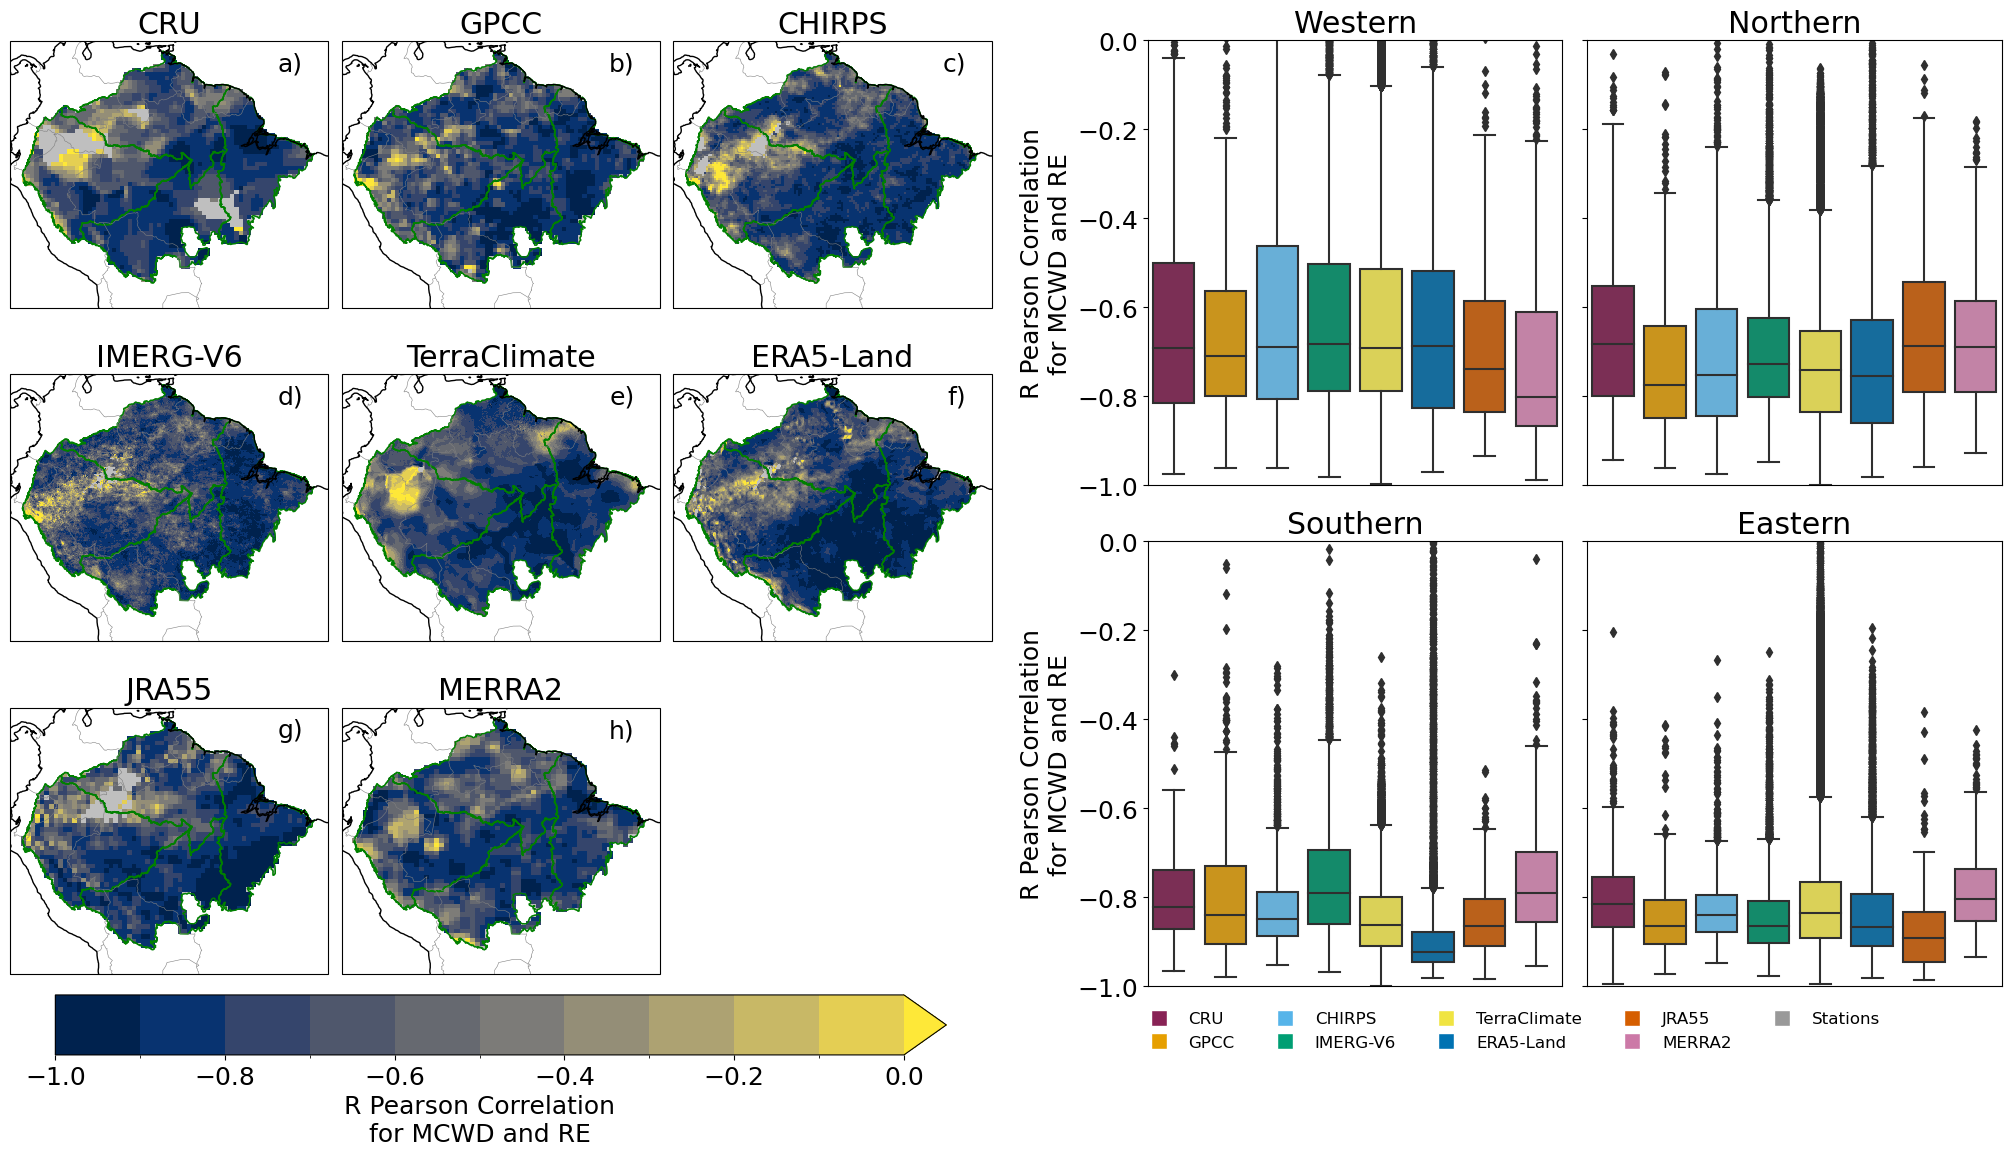

In [70]:
r_ts_plot(datasets_all, 'ent', 'mcwd', label_cbar = 'R Pearson Correlation\nfor MCWD and RE')

C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecat

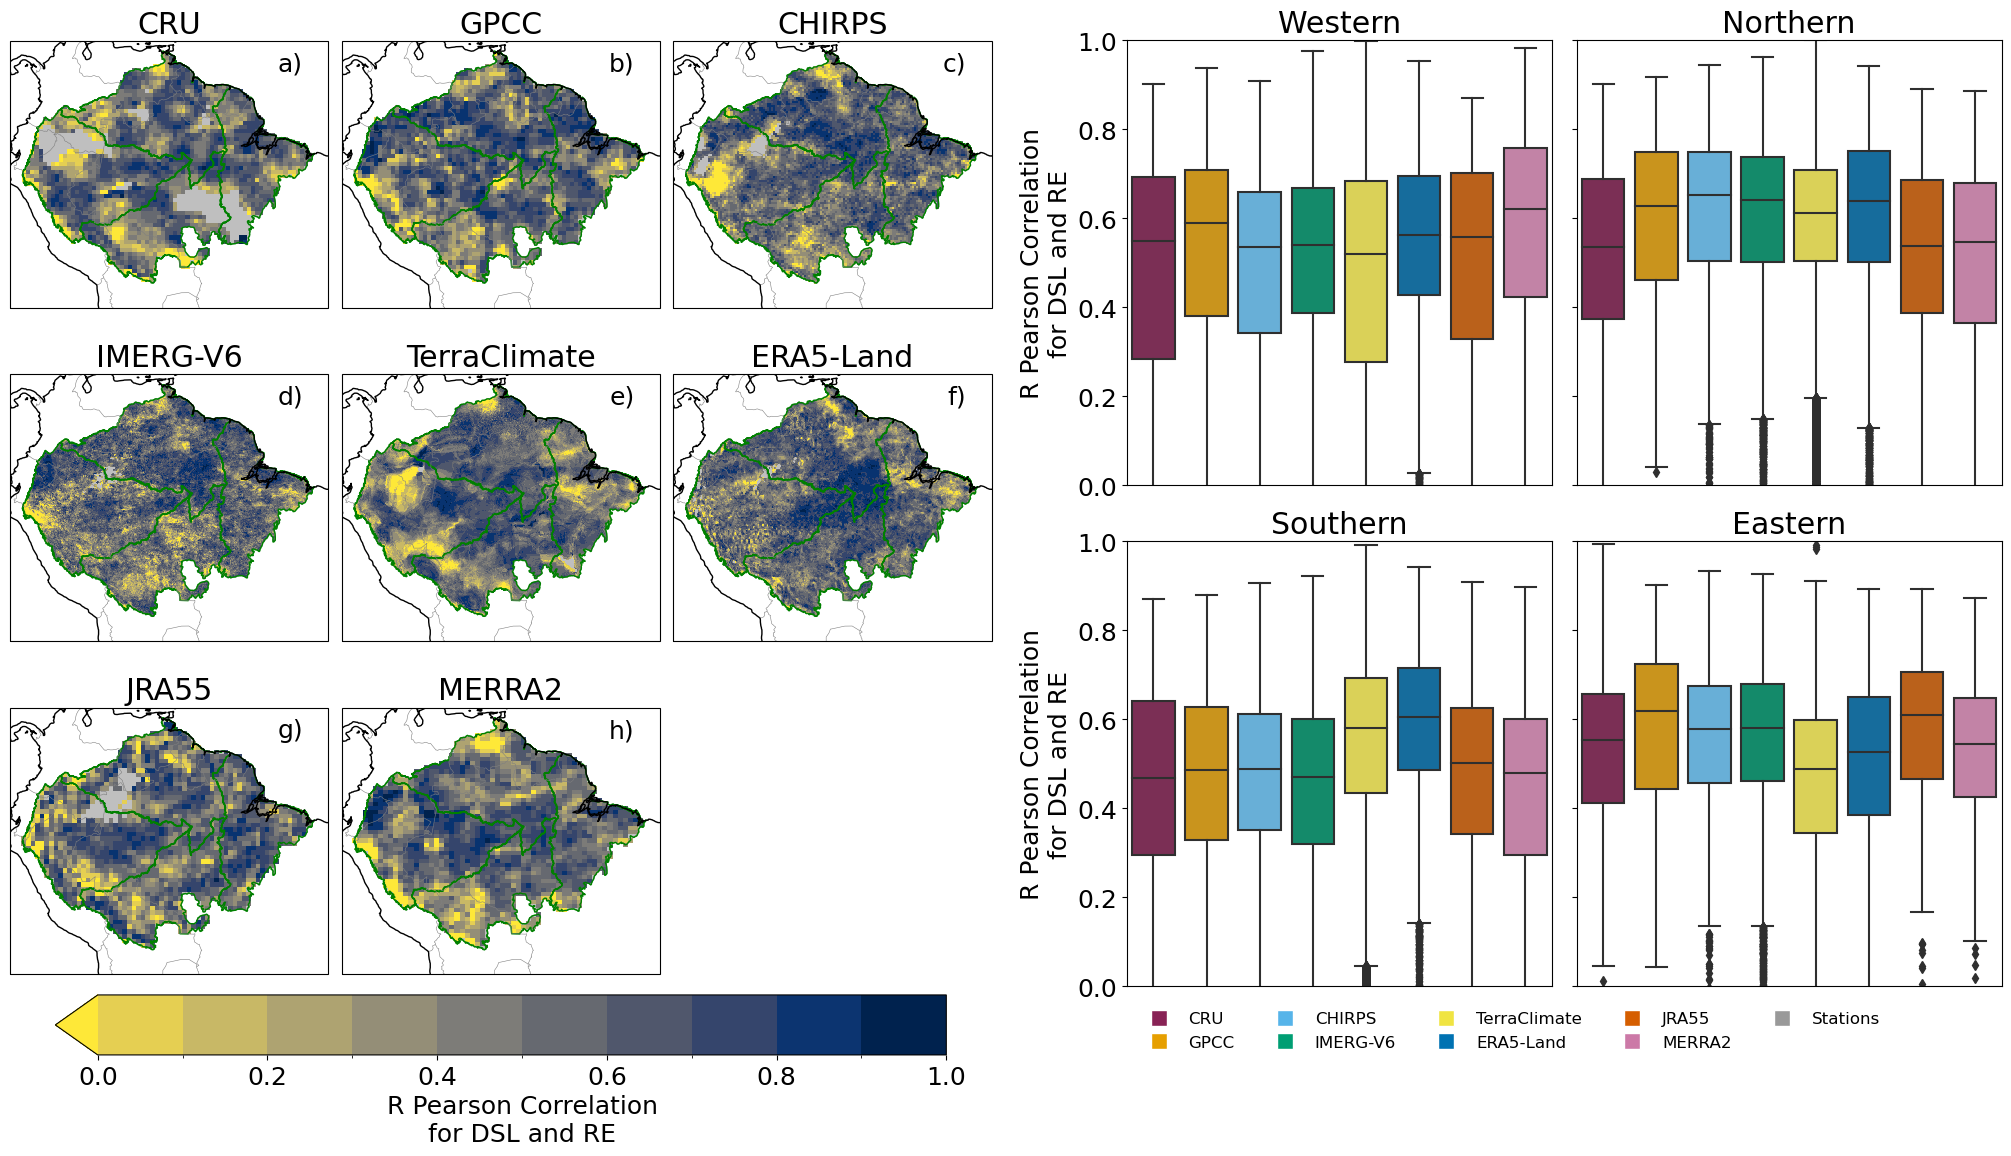

In [72]:
r_ts_plot(datasets_all, 'ent', 'dsl', vmin=0, vmax=1, cmap=mpl.cm.cividis_r,label_cbar = 'R Pearson Correlation\nfor DSL and RE', extend_cbar = 'min')


C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dff)
C:\Users\luisg\AppData\Local\Temp\ipykernel_4212\132638453.py:22: FutureWarning: The frame.append method is deprecat

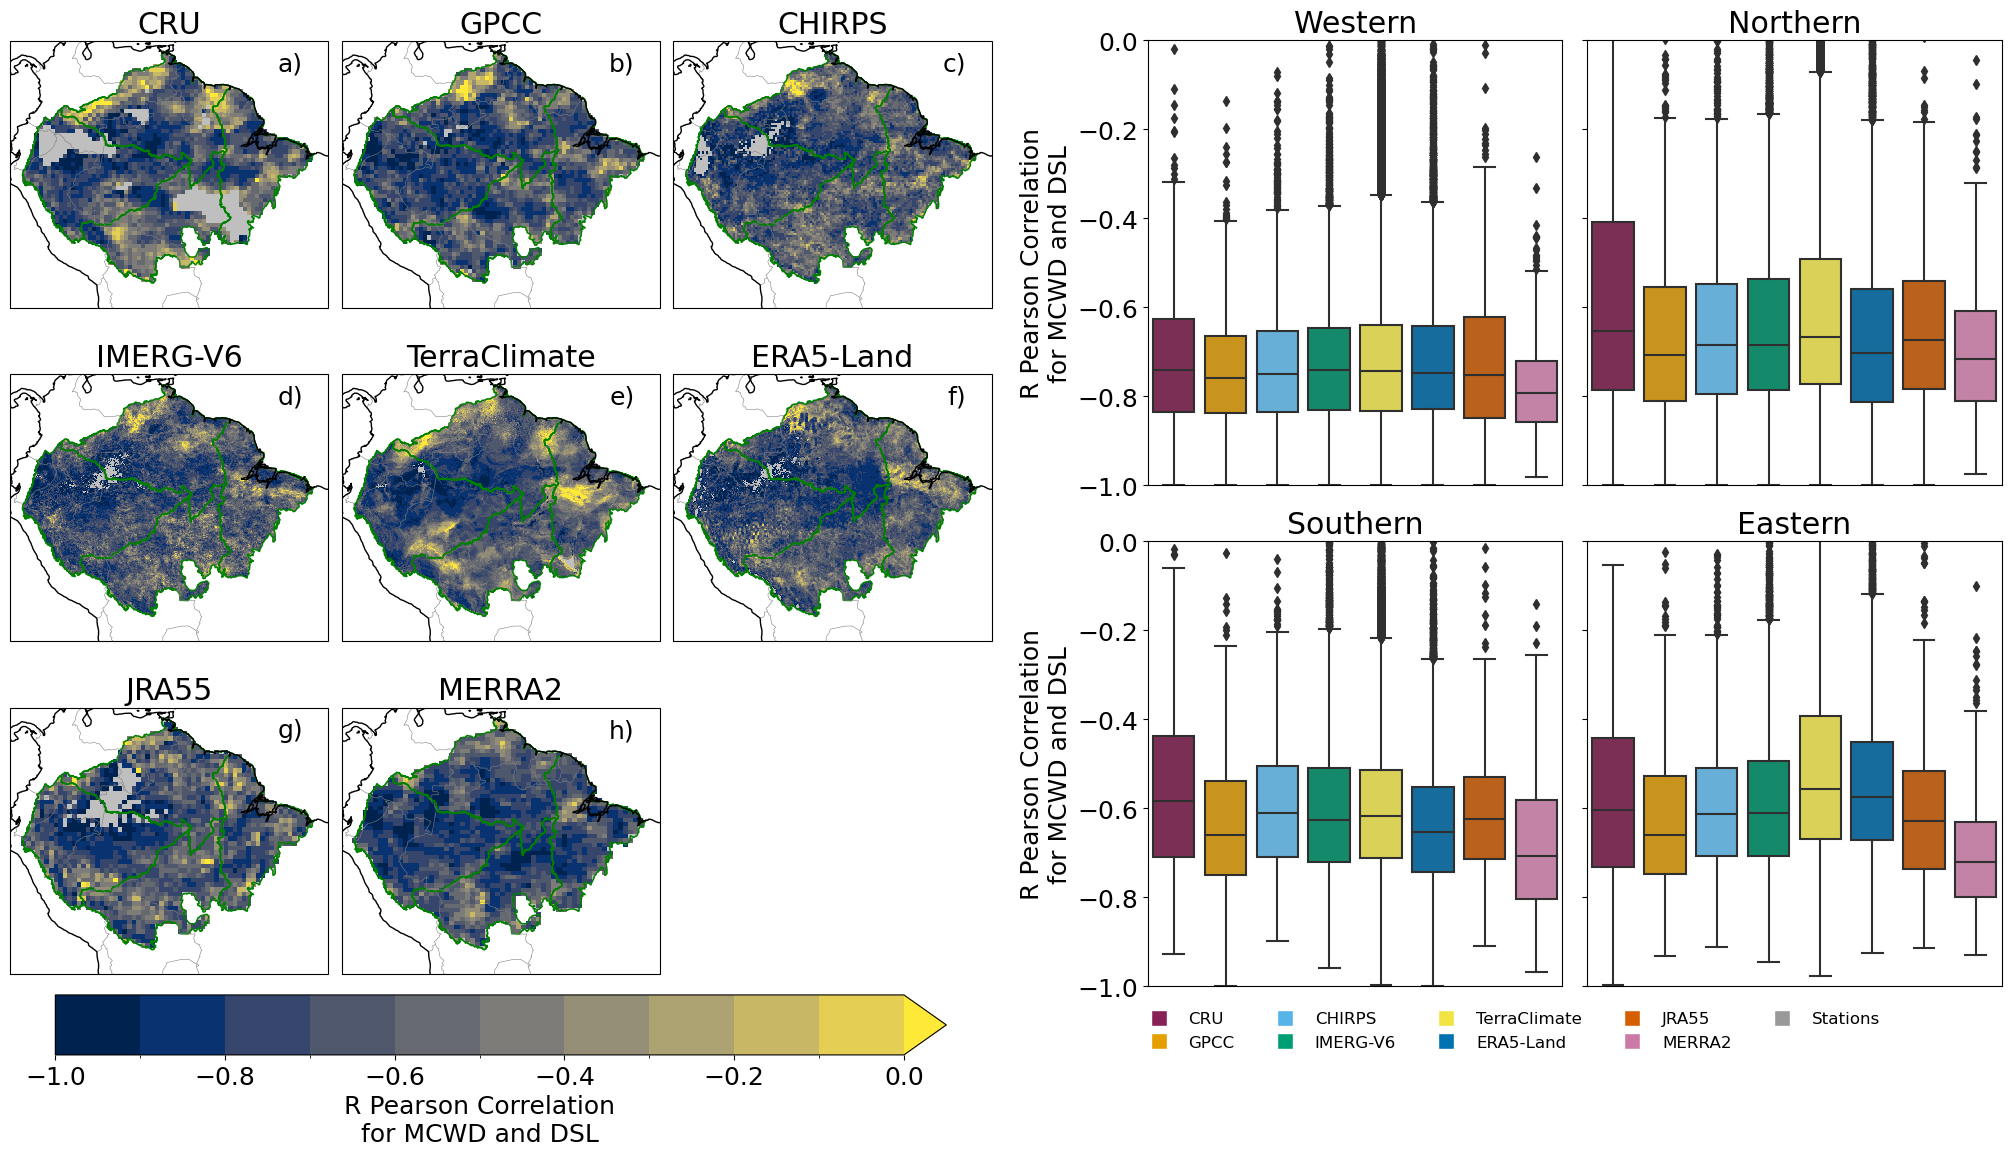

In [73]:
r_ts_plot(datasets_all, 'mcwd', 'dsl', label_cbar = 'R Pearson Correlation\nfor MCWD and DSL')